<a href="https://colab.research.google.com/github/Sanskar6877/ChestXRay_Pneumonia_Detection/blob/main/Model2_Inceptionv3_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.applications import ResNet50
import cv2
import os

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

In [ ]:
!ls /content/drive/MyDrive/

 chest_xray  'Colab Notebooks'


In [ ]:
train = get_data('/content/drive/MyDrive/chest_xray/train')
test = get_data('/content/drive/MyDrive/chest_xray/test')
val = get_data('/content/drive/MyDrive/chest_xray/val')

In [ ]:
val = get_data('/content/drive/MyDrive/chest_xray/val')

In [ ]:
pneumonia = os.listdir("/content/drive/MyDrive/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"

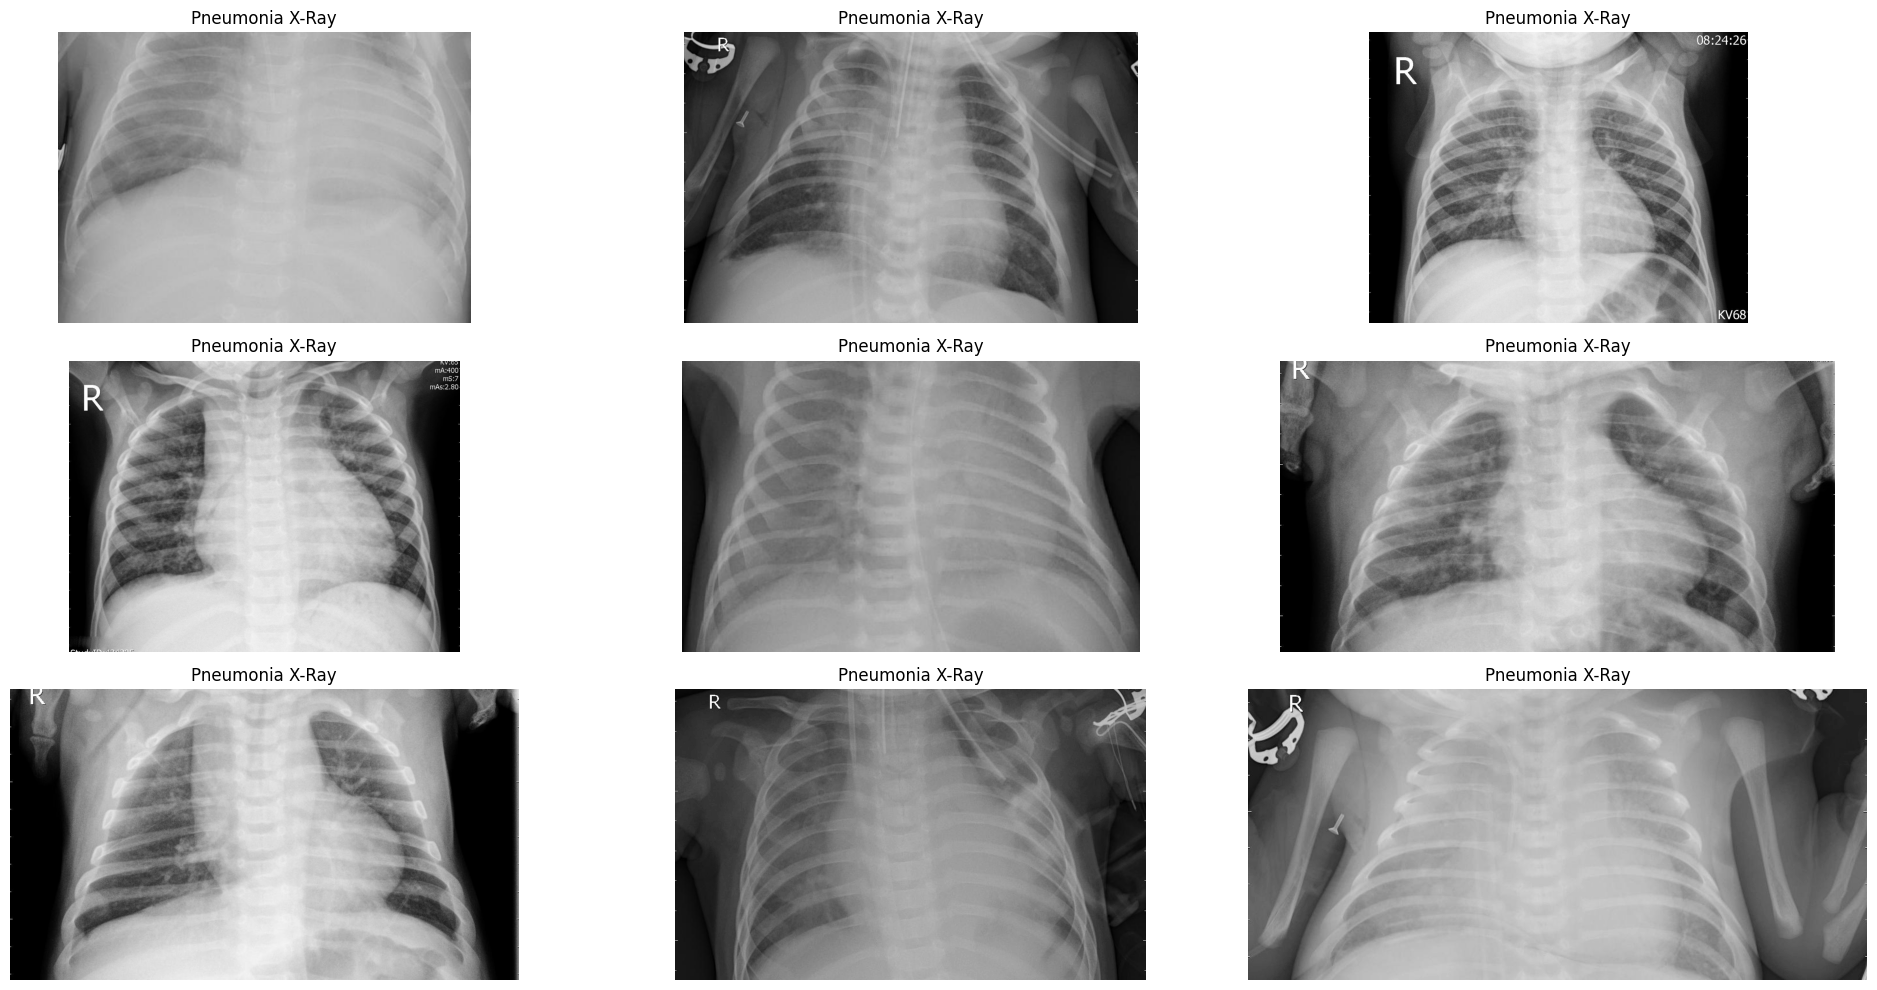

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()

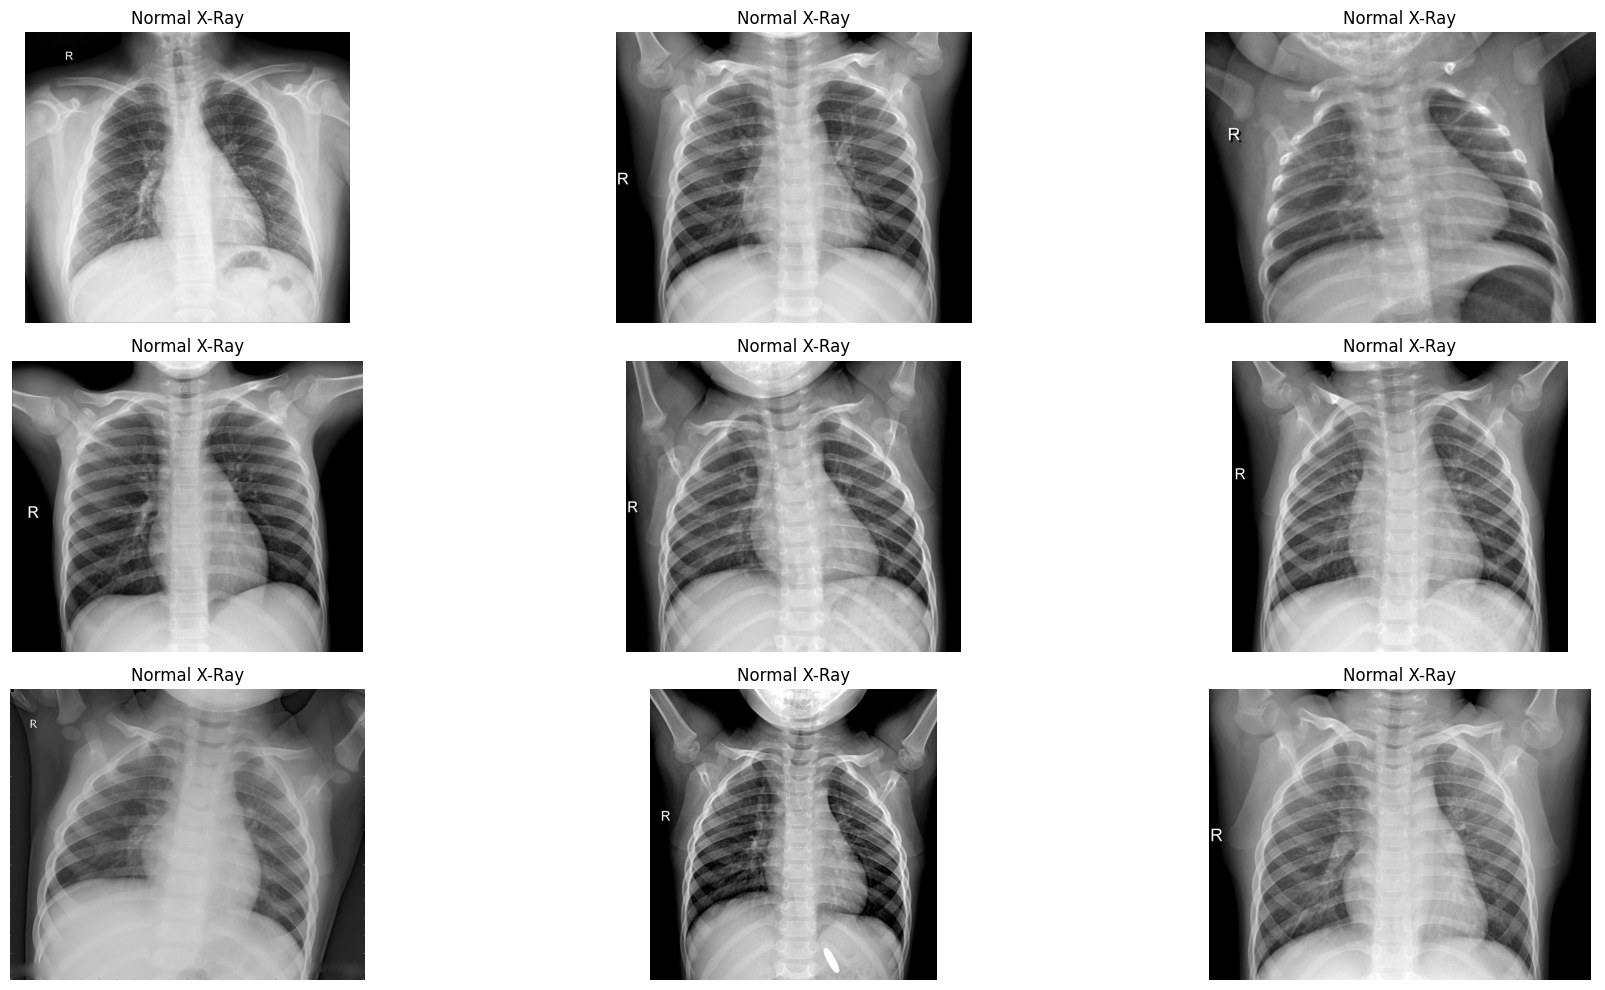

In [ ]:
normal = os.listdir("/content/drive/MyDrive/chest_xray/train/NORMAL")
normal_dir = "/content/drive/MyDrive/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray")

plt.tight_layout()

Text(0.5, 1.0, 'NORMAL')

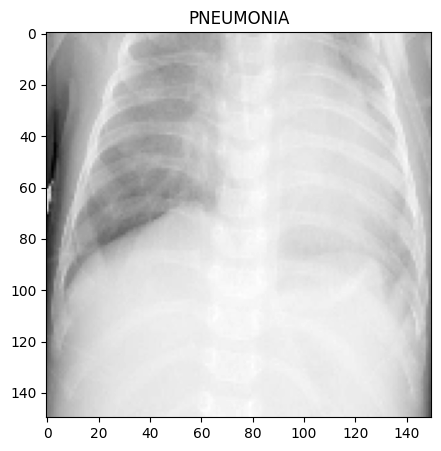

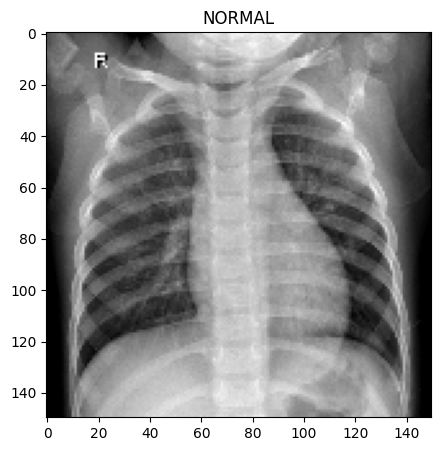

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
len(x_val)

1024

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255


x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling='avg',classes=2)

for layer in base_model.layers[:-2]:
    layer.trainable = False

single_channel_input = Input(shape=(224, 224, 1))

custom_conv_layer = Conv2D(3, (3, 3), padding='same', activation='relu')(single_channel_input)


new_input = Model(inputs=single_channel_input, outputs=custom_conv_layer)
new_input_model = Model(inputs=new_input.input, outputs=base_model(new_input.output))

model = Sequential()
model.add(new_input_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              21802814  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 22852415 (87.18 MB)
Trainable params: 1049631 (4.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.00001)


In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 15 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/15
132/132 [==============================] - 36s 166ms/step - loss: 0.3406 - accuracy: 0.8502 - val_loss: 0.3080 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 2/15
132/132 [==============================] - 16s 118ms/step - loss: 0.2935 - accuracy: 0.8753 - val_loss: 0.2945 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 3/15
132/132 [==============================] - 15s 116ms/step - loss: 0.2671 - accuracy: 0.8881 - val_loss: 0.3263 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 4/15
132/132 [==============================] - 16s 121ms/step - loss: 0.2816 - accuracy: 0.8822 - val_loss: 0.2647 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 5/15
132/132 [==============================] - 16s 123ms/step - loss: 0.2617 - accuracy: 0.8841 - val_loss: 0.2675 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 6/15
132/132 [==============================] - 15s 116ms/step - loss: 0.2597 - accuracy: 0.8907 - val_loss: 0.2530 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 7/15
132/132 [==============================] 

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " ,model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 119ms/step - loss: 0.4064 - accuracy: 0.8221
Loss of the model is -  0.4063933789730072
20/20 [==============================] - 1s 30ms/step - loss: 0.4064 - accuracy: 0.8221
Accuracy of the model is -  82.21153616905212 %


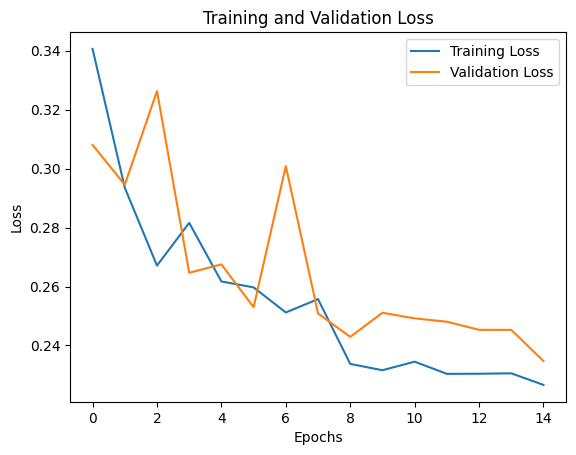

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions
y_pred = model.predict_classes(x_test)

# Convert y_test_encoded back to non-one-hot encoded labels
y_test_non_encoded = np.argmax(y_test, axis=1)

# Calculate precision
precision = precision_score(y_test_non_encoded, y_pred)

# Calculate recall
recall = recall_score(y_test_non_encoded, y_pred)

# Calculate F1-score
f1 = f1_score(y_test_non_encoded, y_pred)

print("Precision of the model is - ", precision)
print("Recall of the model is - ", recall)
print("F1-score of the model is - ", f1)



Precision of the model is -  0.82869
Recall of the model is -  0.832232
F1-score of the model is -  0.84263
